In [1]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime, date, time, timedelta
from typing import Tuple, Union, Optional


# for ML models:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.palettes import Category20
from bokeh.models.widgets import PreText
from bokeh.models import BooleanFilter, ColumnDataSource, IndexFilter, BoxAnnotation, Band, Span, Select, LinearAxis, DataRange1d, Range1d
from bokeh.models.formatters import PrintfTickFormatter, NumeralTickFormatter

# for Data
import yfinance as yf


In [2]:
# Ticker symbol for iShares Core S&P 500 ETF (IVV)
ticker_symbol = "IVV"

# Extracting data
ivv_data = yf.download(ticker_symbol, start="2002-01-01", end="2024-01-01", interval="1d")
ivv_data['Return'] = np.log(ivv_data['Adj Close'].shift(1))
# Displaying the first few rows of the data
print(ivv_data.head())
ivv_data.info()

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close  Adj Close  Volume  \
Date                                                                            
2002-01-02  115.000000  115.570000  113.860001  115.449997  75.894196  987900   
2002-01-03  115.449997  116.779999  115.449997  116.779999  76.768494  359500   
2002-01-04  117.120003  117.860001  116.550003  117.599998  77.307526  154100   
2002-01-07  117.599998  117.959999  116.599998  116.709999  76.722473  220900   
2002-01-08  116.739998  117.019997  116.019997  116.230003  76.406921  124300   

              Return  
Date                  
2002-01-02       NaN  
2002-01-03  4.329340  
2002-01-04  4.340794  
2002-01-07  4.347791  
2002-01-08  4.340195  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5537 entries, 2002-01-02 to 2023-12-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  ----- 

In [3]:
ivv_data.describe(include='all')

,Open,High,Low,Close,Adj Close,Volume,Return
count,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5.537000e+03,5536.000000
mean,204.134851,205.267334,202.882379,204.157000,176.793921,3.473057e+06,4.979741
std,108.970042,109.540483,108.366692,108.996600,115.614783,2.728486e+06,0.613574
min,68.160004,70.129997,67.220001,68.190002,51.105190,4.490000e+04,3.933886
25%,119.559998,120.150002,118.870003,119.599998,86.645660,1.717800e+06,4.461807
50%,153.220001,153.669998,152.330002,152.970001,119.062080,3.137300e+06,4.778735
75%,272.839996,274.760010,270.980011,272.730011,246.639465,4.590100e+06,5.507857
max,481.369995,482.070007,478.519989,479.839996,477.479950,3.874850e+07,6.168522


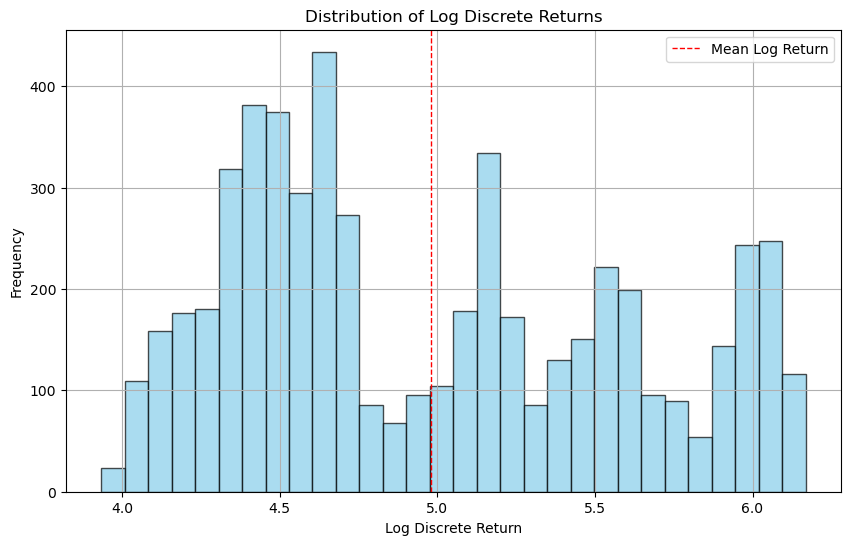

In [4]:
# chach for imbalance in the return: if Skewness is high?
log_returns = ivv_data['Return']


# Plot histogram of log discrete returns
plt.figure(figsize=(10, 6))
plt.hist(log_returns, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Log Discrete Returns')
plt.xlabel('Log Discrete Return')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line indicating the mean of log discrete returns
mean_log_return = log_returns.mean()
plt.axvline(mean_log_return, color='red', linestyle='dashed', linewidth=1, label='Mean Log Return')

# Show legend
plt.legend()

plt.show()

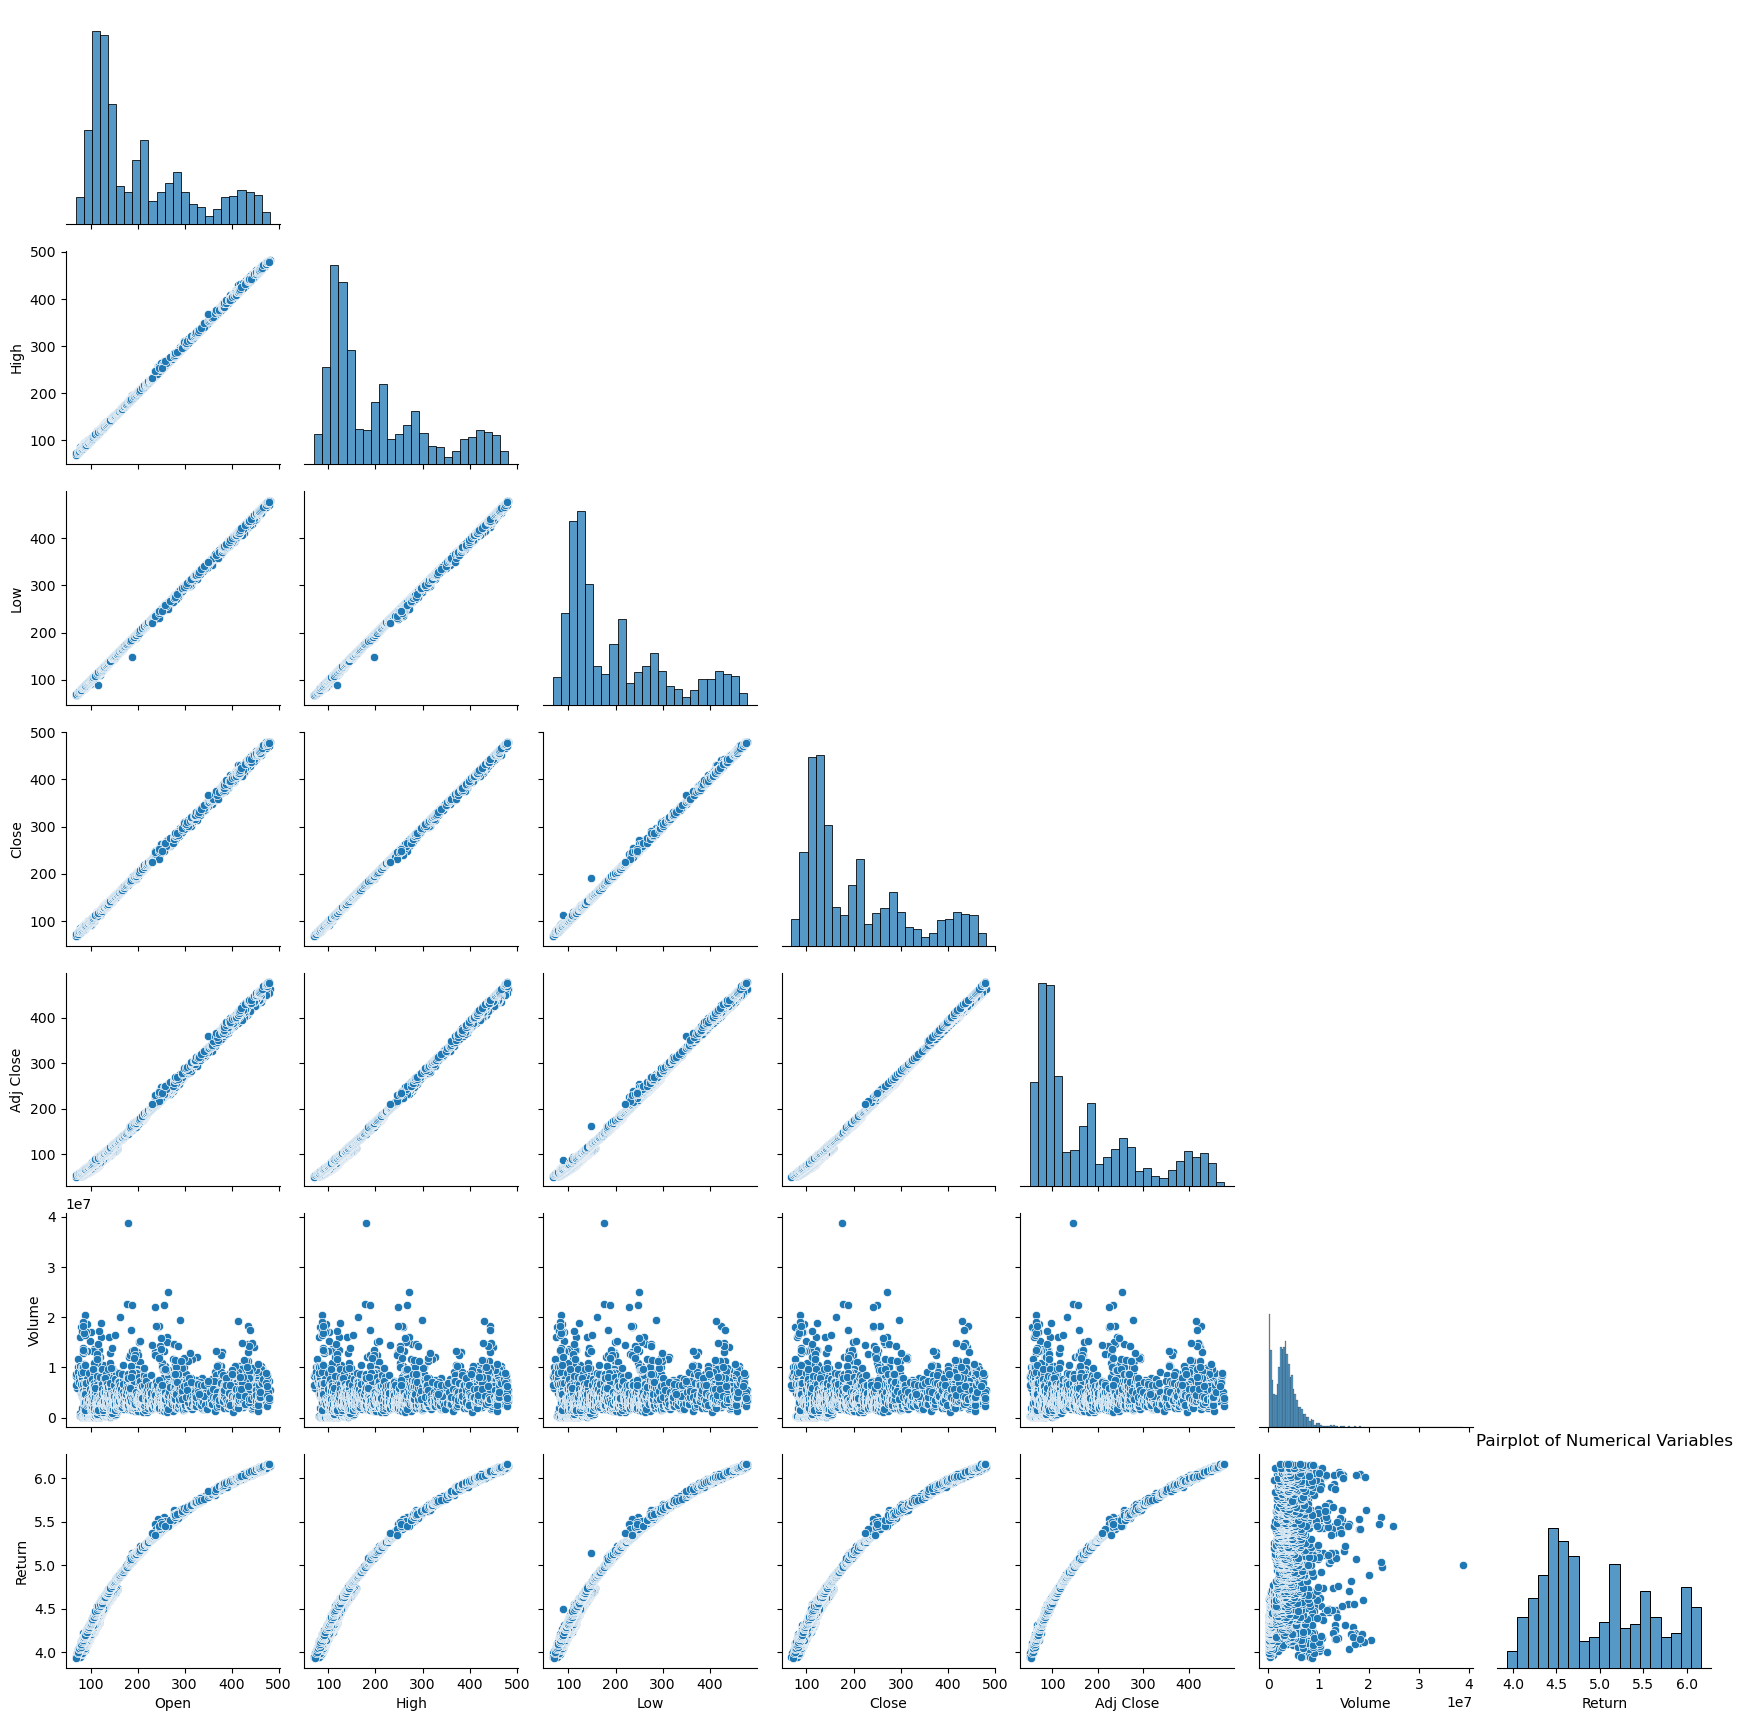

In [5]:
# Pairplot to visualize relationships between numerical variables: No skewness in data -- > low imbalance
sns.pairplot(ivv_data, corner=True)
plt.title('Pairplot of Numerical Variables')
plt.show()

In [6]:
df_A = ivv_data.copy()

# Extract year from the 'DATE' column
df_A['Year'] = df_A.index.dt.year

# Aggregate data by year and compute the mean for each feature
yearly_data = df_A[['Year','Open', 'High', 'Low', 'Close']].groupby('Year').mean()

# Reset index to have 'Year' as a regular column
yearly_data.reset_index(inplace=True)

# Melt the DataFrame to have a single x-axis for all features
melted_yearly_data = yearly_data.melt(id_vars=['Year'], var_name='Feature', value_name='Mean Value')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=melted_yearly_data, x='Year', y='Mean Value', hue='Feature')
plt.title('Yearly Mean of Features')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

In [5]:
# Bollinger Band

def calculate_bollinger_bands(close_prices: np.ndarray, window: int, num_std=2):
    """
    Calculate the Bollinger Bands for a given set of closing prices.

    Parameters:
    - close_prices: List or array of closing prices
    - window: Size of the moving average window (default is 20)
    - num_std: Number of standard deviations for the bands (default is 2)

    Returns:
    - bollinger_upper: List of upper Bollinger Band values
    - bollinger_lower: List of lower Bollinger Band values
    """
    close_series = pd.Series(close_prices)
    rolling_mean = close_series.rolling(window=window).mean()
    rolling_std = close_series.rolling(window=window).std()

    bollinger_upper = rolling_mean + (rolling_std * num_std)
    bollinger_lower = rolling_mean - (rolling_std * num_std)

    return round(bollinger_upper,2), round(bollinger_lower,2)

ivv_data['bolling_upper'], ivv_data['bolling_lower'] = calculate_bollinger_bands(ivv_data['Adj Close'], window=20)

In [6]:
# On-Balance Volume (OBV)
def calculate_obv(close_prices: np.ndarray, volume: np.ndarray) -> np.ndarray:
    """
    Calculate the On-Balance Volume (OBV) for a given set of closing prices and volume.

    Parameters:
    - close_prices: List or array of closing prices
    - volume: List or array of trading volume corresponding to the closing prices

    Returns:
    - obv_values: List of On-Balance Volume (OBV) values
    """
    obv_values = [0]  # Initialize OBV with zero

    for i in range(1, len(close_prices)):
        if close_prices[i] > close_prices[i - 1]:
            obv_values.append(obv_values[i - 1] + volume[i])  # Add volume to OBV for uptrend
        elif close_prices[i] < close_prices[i - 1]:
            obv_values.append(obv_values[i - 1] - volume[i])  # Subtract volume from OBV for downtrend
        else:
            obv_values.append(obv_values[i - 1])  # No change in OBV for no price change

    return obv_values



In [7]:
# MOVING AVERAGES

# Base level analyzed for parameter representing the number of periods n = 15 as proposed by https://www.sciencedirect.com/science/article/pii/S2405918815300179

# Simple Moving Average
# calculate for 15 days         
def calculate_sma(close_prices: np.ndarray, window: int) -> np.ndarray:
    return close_prices.rolling(window=window).mean()

# Weighted Moving Average
# calculate for 15 days
def calculate_wma(close_prices: np.ndarray, window: int) -> np.ndarray:
    
    weights = np.arange(1, window + 1)
    wma =  close_prices.rolling(window=window).apply(lambda price: np.dot(close_prices, weights) / weights.sum(), raw=True)

    return wma.values

# Exponential Moving Average: to reduce lag in responsiveness to price movements.
# calculate for 12, 15, 26
def calculate_ema(close_prices: np.ndarray, window: int) -> np.ndarray:
    return close_prices.ewm(span=window, adjust=False).mean()


# distant of the current price is from MA's
def signal_dist_ma(close_prices: np.ndarray, ma: np.ndarray) -> np.ndarray:
    return close_prices - ma
# sma_15_signal = df['CLOSE'] -  sma_15
# wma_15_signal = df['CLOSE'] - wma_15
# ema_15_signal = df['CLOSE'] - wma_15


In [8]:
# Oscillators

# Moving Average Convergence Divergence
def calculate_macd(close_prices:np.ndarray, 
                   short_window: int, 
                   long_window: int, 
                   signal_window: int):
    # Calculate short-term (fast) EMA
    short_ema = close_prices.ewm(span=short_window, min_periods=1, adjust=False).mean()

    # Calculate long-term (slow) EMA
    long_ema = close_prices.ewm(span=long_window, min_periods=1, adjust=False).mean()

    # Calculate MACD line
    macd = short_ema - long_ema

    # Calculate MACD signal line
    macd_signal = macd.ewm(span=signal_window, min_periods=1, adjust=False).mean()

    # Calculate MACD histogram
    macd_histogram = macd - macd_signal

    return macd_histogram, macd, macd_signal
#macd_12_26 =  ema_12 - ema_26

# Stochastic Oscillator (STOCH) 
def calculate_stoch(close_prices: np.ndarray, 
                    low_prices: np.ndarray, 
                    high_prices: np.ndarray, 
                    n_fast_k=14, 
                    n_fast_d=3,
                    n_slow_d=3):
    # Calculate %K
    L14 = low_prices.rolling(window=n_fast_k).min()
    H14 = high_prices.rolling(window=n_fast_k).max()
    K = close_prices - L14 / (H14 - L14) * 100
    # Calculate %D [fast, slow]
    D_Fast = K.rolling(window=n_fast_d).mean()  
    D_Slow = D_Fast.rolling(window=n_slow_d).mean()
    return K, D_Fast, D_Slow



In [9]:
# Relative Strength Index
# calculate for 14 days
def calculate_rsi(close_prices: np.ndarray, window: int) -> np.ndarray:
    delta = close_prices.diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=window-1 , min_periods=window).mean()
    ema_down = down.ewm(com=window-1 , min_periods=window).mean()
    return ema_up/ema_down

        
# Williams %R: between 0 and -100 
# calculate for 14 days 
def calculate_williams(close_prices: np.ndarray, 
                       low_prices: np.ndarray, 
                       high_prices: np.ndarray, 
                       window: int) -> np.ndarray:
    highest_high = high_prices.rolling(window).max()
    lowest_low = low_prices.rolling(window).min()
    williams = ((highest_high - close_prices) / (highest_high - lowest_low)) * 100
    
    return williams

# Accumulation/Distribution (A/D) Oscillator
def accumulation_distribution(close_prices: np.ndarray, 
                              low_prices: np.ndarray, 
                              high_prices: np.ndarray) -> np.ndarray:
    accumulation_distribution_values = []
    for i in range(1, len(close_prices)):
        money_flow = (close_prices[i] - low_prices[i]) - (high_prices[i] - close_prices[i - 1])
        high_low_range = high_prices[i] - low_prices[i]
        ad_oscillator = money_flow + accumulation_distribution_values[-1] if accumulation_distribution_values else money_flow
        accumulation_distribution_values.append(ad_oscillator)
    return accumulation_distribution_values
# Commodity Channel Index (CCI)

Target(Dependable) Variable : 
    Trading Signal [Buy, Sell] https://core.ac.uk/download/pdf/239040003.pdf


y pred: is the the predicted return from a regression model

Signal = 
\begin{cases}
1 & \text{if}\quad y_{\text{pred}}(t) \geq q_{0.6} \\
0 & \text{if}\quad q_{0.4} < y_{\text{pred}}(t) < q_{0.6} \\
-1 & \text{if}\quad y_{\text{pred}}(t) \leq q_{0.4}
\end{cases}


In [10]:
def calculate_signals(y_pred: np.ndarray, q_low=0.4, q_high=0.6) -> np.ndarray:
    """
    Calculate trading signals based on predicted values and quantiles.
    signalt = {1  yt ≥ q0.6
               0  q0.4 < yt < q0.6 
               −1 yt ≤ q0.4}
    Parameters:
        y_pred (np.ndarray): Predicted values.

    Returns:
        np.ndarray: Trading signals.
    """
    q_40 = np.quantile(y_pred, q_low)
    q_60 = np.quantile(y_pred, q_high)
    signals = np.zeros_like(y_pred)  # Initialize signals vector with zeros

    # Calculate signals based on quantiles
    signals[y_pred >= q_60] = 1  # Buy signal
    signals[(y_pred > q_40) & (y_pred < q_60)] = 0  # Neutral signal
    signals[y_pred <= q_40] = -1  # Sell signal

    return signals

In [11]:
# create df of indicators:
df = pd.DataFrame(index=ivv_data.index)
df['boll_upper'], df['boll_lower'] = ivv_data['bolling_upper'], ivv_data['bolling_lower']
df['obv'] = calculate_obv(ivv_data['Adj Close'], ivv_data['Volume'])
df['sma'] = ivv_data['Adj Close'] - calculate_sma(ivv_data['Adj Close'], window=15)
df['ema'] = calculate_ema(ivv_data['Adj Close'], window=15)
_, _, df['macd'] = calculate_macd(ivv_data['Adj Close'], short_window=12, long_window=26, signal_window=15)
df['k'], df['d_fast'], df['d_slow'] = calculate_stoch(ivv_data['Adj Close'], ivv_data['Low'], ivv_data['High'])
df['rsi'] = calculate_rsi(ivv_data['Adj Close'], window=15)
df['williams_r'] = calculate_williams(ivv_data['Adj Close'], ivv_data['Low'], ivv_data['High'], window=15)
df['return'] = ivv_data['Return']


df

,boll_upper,boll_lower,obv,sma,ema,macd,k,d_fast,d_slow,rsi,williams_r,return
Date,,,,,,,,,,,,
2002-01-02,NaN,NaN,0,NaN,75.894196,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,NaN,NaN,359500,NaN,76.003483,0.008718,NaN,NaN,NaN,NaN,NaN,4.329340
2002-01-04,NaN,NaN,513600,NaN,76.166488,0.028452,NaN,NaN,NaN,NaN,NaN,4.340794
2002-01-07,NaN,NaN,292700,NaN,76.235986,0.049134,NaN,NaN,NaN,NaN,NaN,4.347791
2002-01-08,NaN,NaN,168400,NaN,76.257353,0.066481,NaN,NaN,NaN,NaN,NaN,4.340195
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,479.12,446.19,523809200,9.002264,466.328811,7.095403,-1542.705126,-1544.894813,-1532.793136,2.448258,21.078055,6.159947
2023-12-26,480.73,446.88,526044900,9.659206,467.581899,7.204355,-1540.661638,-1542.326331,-1533.575489,2.639665,12.048051,6.161861
2023-12-27,482.23,447.74,529805900,9.112673,468.791739,7.304127,-1573.008737,-1552.125167,-1546.448770,2.730700,8.039631,6.166160


Normalization techniques: 
https://itadviser.dev/stock-market-data-normalization-for-time-series/#:~:text=Moving%20average%20normalization%20smoothens%20out,price%20by%20its%20moving%20average.

Data transformation: min-max normalization (rescaled to range from -1 to 1):

$x'_t = \left(\frac{x_t - \min(x)}{\max(x) - \min(x)}\right) \times 2 - 1$


In [12]:
def min_max_scale_df(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.values)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
    return scaled_df


In [13]:
scaled_df = min_max_scale_df(df)
scaled_df = scaled_df.dropna()
scaled_df

,boll_upper,boll_lower,obv,sma,ema,macd,k,d_fast,d_slow,rsi,williams_r,return
Date,,,,,,,,,,,,
2002-01-30,0.047738,0.059124,0.094322,0.655931,0.047575,0.669338,0.872281,0.825141,0.799955,0.066391,0.284298,0.156342
2002-01-31,0.047551,0.058950,0.094487,0.669536,0.047530,0.668021,0.871654,0.846024,0.819301,0.099552,0.322019,0.162749
2002-02-01,0.047012,0.058825,0.093324,0.665743,0.047363,0.666923,0.850402,0.838833,0.830376,0.086120,0.326759,0.167921
2002-02-04,0.046473,0.058102,0.093178,0.644237,0.046691,0.665294,0.850232,0.830001,0.832063,0.049281,0.384559,0.165343
2002-02-05,0.046192,0.057181,0.093045,0.641410,0.045977,0.663208,0.825764,0.811618,0.820121,0.043162,0.388372,0.154634
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.988171,0.989760,0.762928,0.799194,0.989593,0.985821,0.851614,0.822757,0.817365,0.356518,0.007871,0.996163
2023-12-26,0.991942,0.991479,0.765785,0.808468,0.992606,0.990471,0.851813,0.823057,0.817270,0.387103,0.002420,0.997019
2023-12-27,0.995456,0.993622,0.770592,0.800752,0.995515,0.994729,0.848669,0.821913,0.815704,0.401650,0.000000,0.998943


In [14]:
WIDTH_PLOT = 1500

RED = Category20[7][6]
GREEN = Category20[5][4]

BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]

ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]

TOOLS = 'pan,wheel_zoom,reset'

# Main chart for stock prices with candlestick and Bolinger bands
def plot_stock_price(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=400,
               title="Stock price + Bollinger Bands (2 std)",
               tools=TOOLS, toolbar_location='above')

    inc_data = stock[stock['Close'] > stock['Open']]
    dec_data = stock[stock['Open'] > stock['Close']]

    width = 35000000

    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=RED, source=inc_data)
    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=GREEN, source=dec_data)

    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=RED, line_color=RED,
           source=inc_data)
    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=GREEN, line_color=GREEN,
           source=dec_data)

    # p.line(x='date', y='close_line', line_width=1, color=BLUE, line_alpha=0.7, souce=stock)
    # Creating vertices for the cloud-like shape between Bollinger Bands
    cloud_x = list(stock['Date']) + list(stock['Date'][::-1])
    cloud_y = list(stock['bolling_upper']) + list(stock['bolling_lower'][::-1])

    cloud_source = ColumnDataSource(data=dict(x=cloud_x, y=cloud_y))

    # Creating the patch for the cloud-like shape
    p.patch('x', 'y', color=BLUE_LIGHT, line_color='black', alpha=0.3, source=cloud_source)

    code = """
    def ticker():
        return "{:.0f} + {:.2f}".format(tick, tick % 1)
    """
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')

    return p


# Simple Moving Average
def plot_sma(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=300,
               title="Simple Moving Average (press the legend to hide/show lines)",
               tools=TOOLS, toolbar_location='above')

    p.line(x='DATE', y='SMA_5', line_width=2, color=BLUE, source=stock, legend_label='5 days', muted_color=BLUE,
           muted_alpha=0.2)
    p.line(x='DATE', y='SMA_10', line_width=2, color=ORANGE, source=stock, legend_label='10 days', muted_color=ORANGE,
           muted_alpha=0.2)
    p.line(x='DATE', y='SMA_50', line_width=2, color=PURPLE, source=stock, legend_label='50 days', muted_color=PURPLE,
           muted_alpha=0.2)
    p.line(x='DATE', y='SMA_100', line_width=2, color=BROWN, source=stock, legend_label='100 days', muted_color=BROWN,
           muted_alpha=0.2)

    p.legend.location = "bottom_right"
    p.legend.border_line_alpha = 0
    p.legend.background_fill_alpha = 0
    p.legend.click_policy = "mute"
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')

    return p


# MACD (line + histogram)
def plot_macd(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=300, title="MACD (line + histogram)",
               tools=TOOLS, toolbar_location='above')

    up = stock[stock['macd_histogram'] > 0]
    down = stock[stock['macd_histogram']<0]


    p.vbar(x='DATE', top='macd_histogram', bottom=0, width=30000000, color=GREEN, source=up, legend_label='MACD Histogram (Positive)')
    p.vbar(x='DATE', top=0, bottom='macd_histogram', width=30000000, color=RED, source=down,legend_label='MACD Histogram (Negative)')

    # Adding an extra range for the MACD lines, because using the same axis as the histogram
    # sometimes flattens them too much
    p.extra_y_ranges = {'macd': DataRange1d()}
    p.add_layout(LinearAxis(y_range_name='macd'), 'right')

    p.line(x='DATE', y='macd', line_width=2, color=BLUE, source=stock, legend_label='MACD', muted_color=BLUE,
           muted_alpha=0, y_range_name='macd')
    p.line(x='DATE', y='macd_signal', line_width=2, color=BLUE_LIGHT, source=stock, legend_label='Signal',
           muted_color=BLUE_LIGHT, muted_alpha=0, y_range_name='macd')

    p.legend.location = "bottom_left"
    p.legend.border_line_alpha = 0
    p.legend.background_fill_alpha = 0
    p.legend.click_policy = "mute"

    p.yaxis.ticker = []
    p.yaxis.axis_line_alpha = 0

    return p


# RSI
def plot_rsi(stock):
    p = figure(x_axis_type="datetime", plot_width=WIDTH_PLOT, plot_height=200, title="RSI 14 days",
               tools=TOOLS, toolbar_location='above')

    p.line(x='DATE', y='rsi_14', line_width=2, color=BLUE, source=stock)

    low_box = BoxAnnotation(top=30, fill_alpha=0.1, fill_color=RED)
    p.add_layout(low_box)
    high_box = BoxAnnotation(bottom=70, fill_alpha=0.1, fill_color=GREEN)
    p.add_layout(high_box)

    # Horizontal line
    hline = Span(location=50, dimension='width', line_color='black', line_width=0.5)
    p.renderers.extend([hline])

    p.y_range = Range1d(0, 100)
    p.yaxis.ticker = [30, 50, 70]
    p.yaxis.formatter = PrintfTickFormatter(format="%f%%")
    p.grid.grid_line_alpha = 0.3

    return p


#### On-Balance Volume (OBV)
def plot_obv(stock):
    p = figure(x_axis_type="datetime", plot_width=WIDTH_PLOT, plot_height=200, title="On-Balance Volume (OBV)",
               tools=TOOLS, toolbar_location='above')
    p.line(x='DATE', y='OBV', line_width=2, color=BLUE, source=stock)

    p.yaxis.ticker = []
    p.yaxis.axis_line_alpha = 0

    return p


#### Volume line
def plot_volume(stock):
    p = figure(x_axis_type="datetime", plot_width=WIDTH_PLOT, plot_height=200, title="Volume", tools=TOOLS,
               toolbar_location='above')
    p.line(x='DATE', y='VOLUME', line_width=2, color=BLUE, source=stock)

    return p


#### Plot of symbols to choose TICKET
def widget_symbols():
    # Get all symbols
    all_stocks_call = 'https://api.iextrading.com/1.0/ref-data/symbols'
    response = requests.get(all_stocks_call)
    respon = response.json()

    symbols = []
    for e in respon:
        if e['type'] != 'N/A':
            symbols.append(e['symbol'])

    select_ticket = Select(value="AAPL", options=symbols)
    return select_ticket


def widget_show_text(text):
    pre = PreText(text=text, width=500, height=10)

    return pre

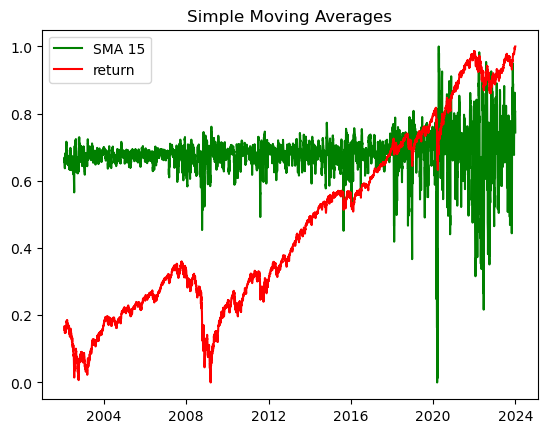

In [15]:
plt.plot(scaled_df['sma'], color='green', label='SMA 15')
plt.plot(scaled_df['return'], color='red', label='return')
plt.legend()
plt.title('Simple Moving Averages')
plt.show()

WFO : walk- forward optimization
|X||V|O|O|O|
|O|X||V|O|O|
|O|O|X||V|O|
|O|O|O|X||V|

X = train, V = validation , ||=indicates a gap (parameter n_gap: int>0) truncated at the beginning of the validation set, in order to prevent leakage effects.

In [16]:
# WFO : walk- forward optimization
class StratifiedWalkForward(object):
    
    def __init__(self,n_splits,n_gap):
        self.n_splits = n_splits
        self.n_gap = n_gap
        self._cv = StratifiedKFold(n_splits=self.n_splits+1,shuffle=False)
        return
    
    def split(self,X,y,groups=None):
        splits = self._cv.split(X,y)
        _ixs = []
        for ix in splits: 
            _ixs.append(ix[1])
        for i in range(1,len(_ixs)): 
            yield tuple((_ixs[i-1],_ixs[i][_ixs[i]>_ixs[i-1][-1]+self.n_gap]))
            
    def get_n_splits(self,X,y,groups=None):
        return self.n_splits

# numFold = 5
# lC = list(np.linspace(0.0005, 1.5, 15))
# numC = len(lC)
# mACC = np.zeros(shape = (numFold, numC)) #<! Accuracy per Fold and Model

# for ii, (vTrainIdx, vTestIdx) in enumerate(StratifiedWalkForward.split(mX, vY)):
#     print(f'Working on Fold #{(ii + 1):02d} Out of {numFold} Folds')
#     #===========================Fill This===========================#
#     # Setting the Train / Test split
#     mXTrain = mX[vTrainIdx, :]
#     vYTrain = vY[vTrainIdx]
#     mXTest  = mX[vTestIdx, :]
#     vYTest  = vY[vTestIdx]
#     #===============================================================#
#     for jj, C in enumerate(lC):
#         print(f'Working on Model #{(jj + 1):02d} Out of {numC} Models with C = {C:0.4f}')
#         #===========================Fill This===========================#
#         # Set the model, train, score
#         # Set `max_iter = maxItr`
#         # Set `dual = False`
#         oSvmCls     = ???
#         # oSvmCls     = SVC(C = C)
#         oSvmCls     = ???
#         accScore    = ???
#         #===============================================================#
#         mACC[ii, jj] = accScore
    
# vAvgAcc = np.mean(mACC, axis = 0) #<! Accuracy

# Plot Results

# hF, hA = plt.subplots(figsize = (8, 8))
# hA.plot(lC, vAvgAcc)
# hA.scatter(lC, vAvgAcc, s = 100)
# hA.set_title(f'Accuracy Score as a Function of C - Average of {numFold} Folds')
# hA.set_xlabel('C')
# hA.set_ylabel('Accuracy')
# hA.set_xticks(lC)
# hA.grid()

# plt.show()

In [17]:
def build_rolling_calendar(start_date, end_date, out_of_sample_size, runs, n_gap):
    days = (end_date - start_date).days

    in_sample_size = (100 - out_of_sample_size) / 100
    out_of_sample_size = out_of_sample_size / 100

    total_days_per_run = round(days / (runs * out_of_sample_size + in_sample_size))
    in_sample_days_per_run = round(total_days_per_run * in_sample_size)
    out_of_sample_days_per_run = round(total_days_per_run * out_of_sample_size)

    calendar = pd.DataFrame()

    calendar['InSampleStarts'] = [start_date + timedelta(days=(out_of_sample_days_per_run * x))
                                  for x in range(runs)]
    calendar['InSampleEnds'] = [x + timedelta(days=in_sample_days_per_run)
                                for x in calendar['InSampleStarts']]

    calendar['OutSampleStarts'] = [start_date + timedelta(days=in_sample_days_per_run + n_gap) +
                                   timedelta(days=(out_of_sample_days_per_run * x))
                                   for x in range(runs)]
    calendar['OutSampleEnds'] = [x + timedelta(days=out_of_sample_days_per_run)
                                 for x in calendar['OutSampleStarts']]

    return calendar

In [18]:
scaled_df.index.min()

Timestamp('2002-01-30 00:00:00')

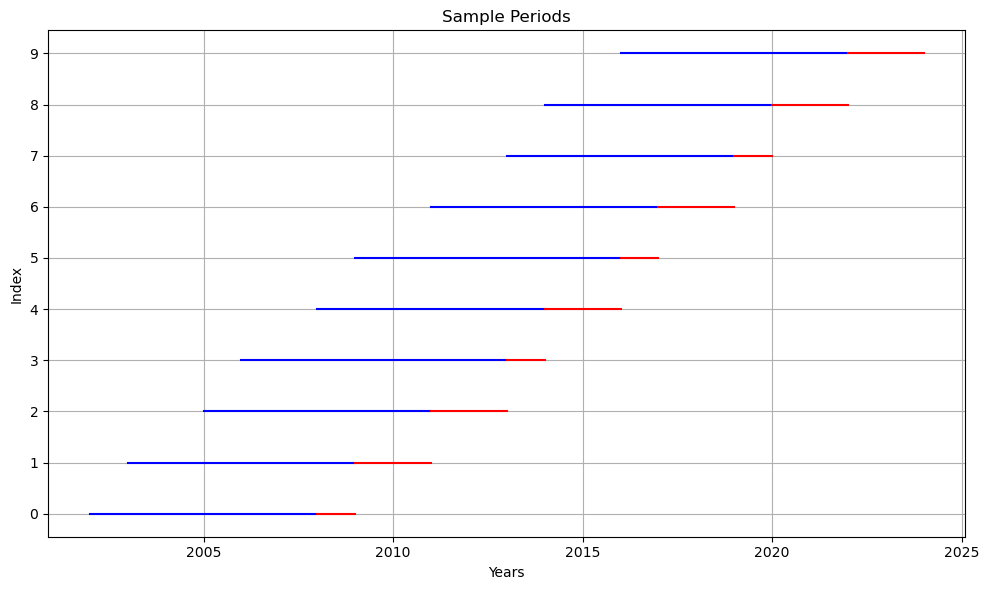

In [19]:
groups = 10
train = np.array(scaled_df)
X, y = train[:, :-1], train[:, -1]
calendar = build_rolling_calendar(start_date=scaled_df.index.min(), end_date=scaled_df.index.max(), out_of_sample_size=20, runs=10, n_gap=20)


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, row in calendar.iterrows():
    ax.plot([row['InSampleStarts'].year, row['InSampleEnds'].year], [i, i], color='blue')
    ax.plot([row['OutSampleStarts'].year, row['OutSampleEnds'].year], [i, i], color='red')

# Customize plot
ax.set_yticks(calendar.index.values[::-1])
ax.set_yticklabels(calendar.index.values[::-1])
ax.set_xlabel('Years')
ax.set_ylabel('Index')
ax.set_title('Sample Periods')
ax.grid(True)

plt.tight_layout()
plt.show()

In [24]:
calendar

,InSampleStarts,InSampleEnds,OutSampleStarts,OutSampleEnds
0,2002-01-30,2008-05-04,2008-05-24,2009-12-17
1,2003-08-25,2009-11-27,2009-12-17,2011-07-12
2,2005-03-19,2011-06-22,2011-07-12,2013-02-03
3,2006-10-12,2013-01-14,2013-02-03,2014-08-29
4,2008-05-06,2014-08-09,2014-08-29,2016-03-23
5,2009-11-29,2016-03-03,2016-03-23,2017-10-16
6,2011-06-24,2017-09-26,2017-10-16,2019-05-11
7,2013-01-16,2019-04-21,2019-05-11,2020-12-03
8,2014-08-11,2020-11-13,2020-12-03,2022-06-28
9,2016-03-05,2022-06-08,2022-06-28,2024-01-21


In [20]:
X_train = []
X_test = []
y_train = []
y_test = []
for i, row in calendar.iterrows():
    train = scaled_df.loc[row['InSampleStarts']: row['InSampleEnds']].to_numpy()
    X_train.append(train[:, :-1])
    y_train.append(train[:, -1])
    test = scaled_df.loc[row['OutSampleStarts']: row['OutSampleEnds']].to_numpy()
    X_test.append(test[:, :-1])
    y_test.append(test[:,-1])
    

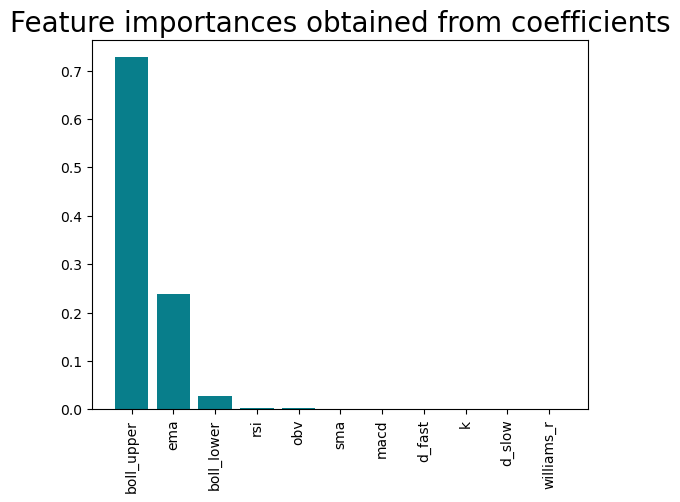

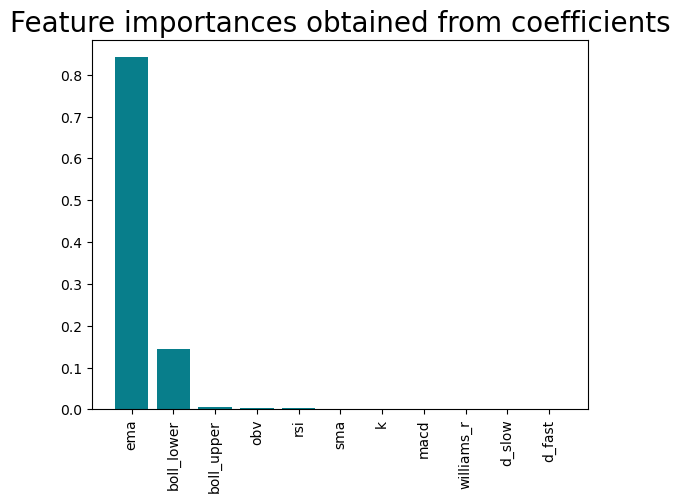

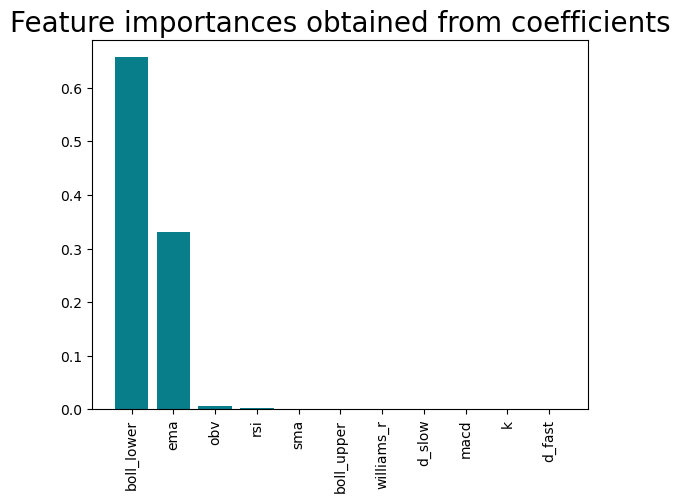

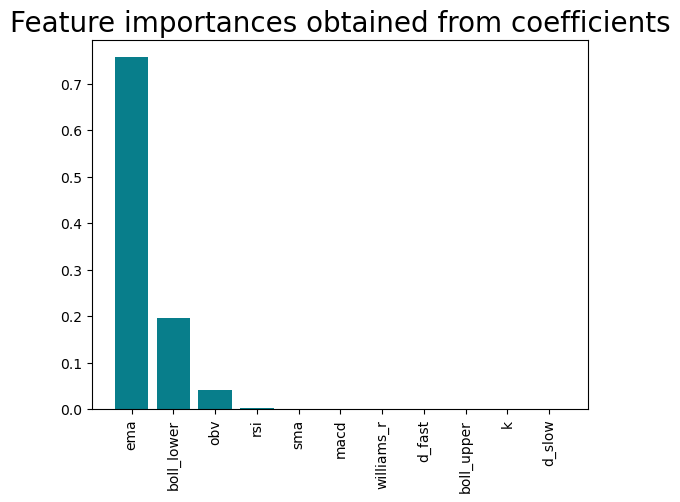

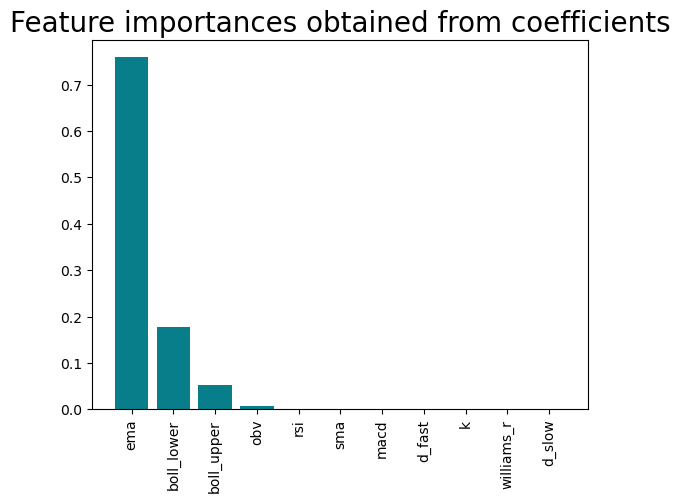

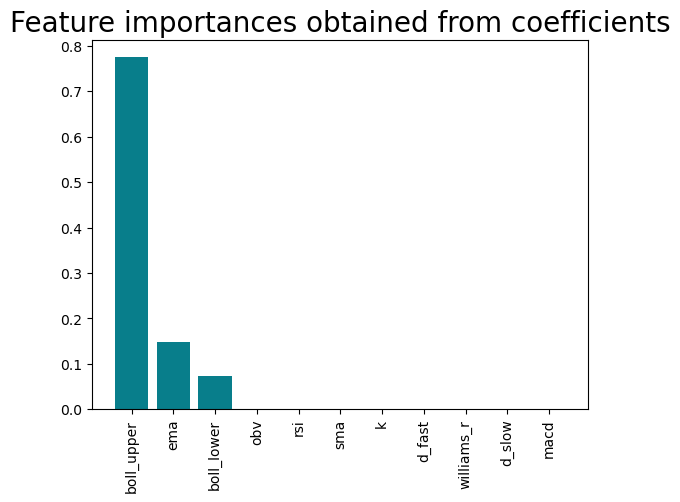

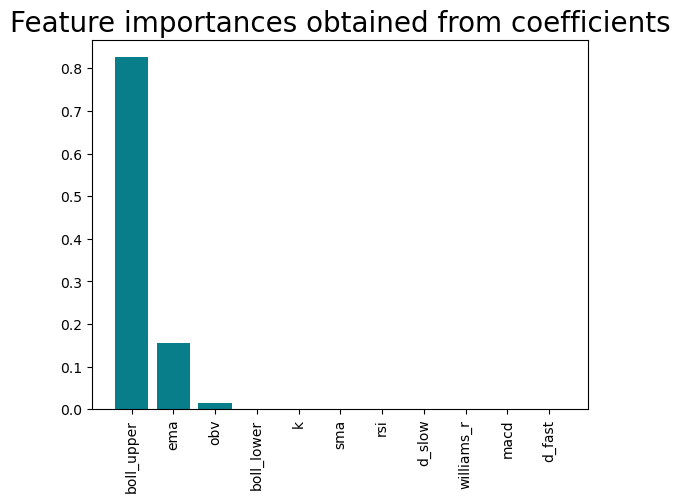

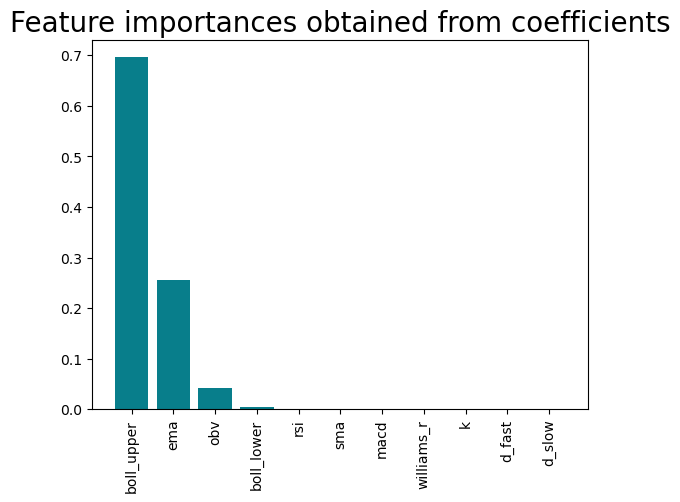

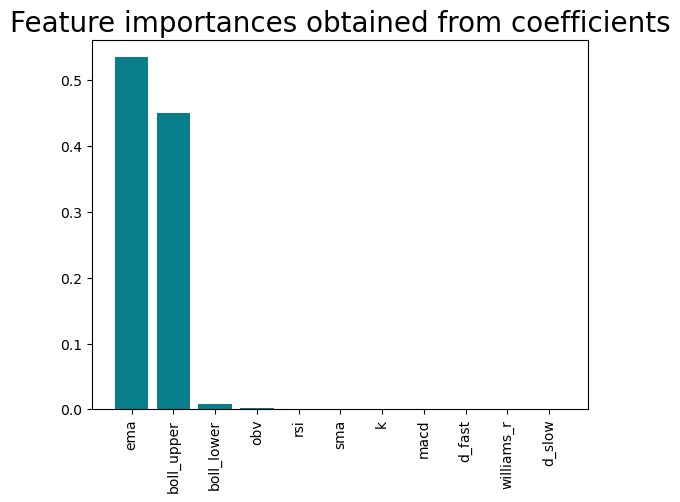

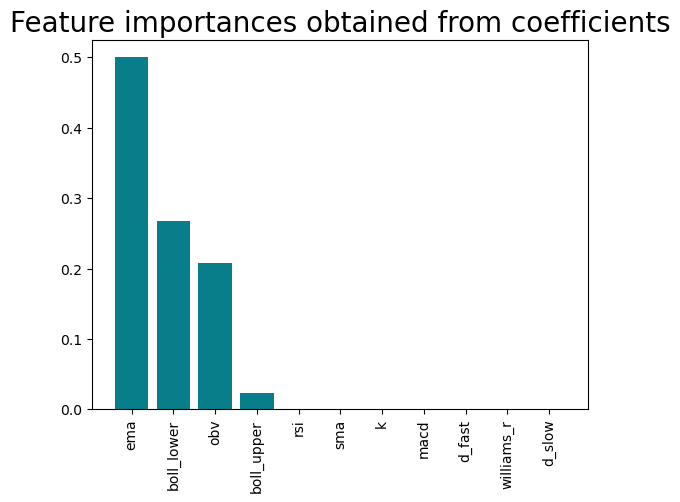

In [21]:
# Check first xgboost feature importance:
from xgboost import XGBRegressor
# train =  scaled_df.to_numpy()
# X_train_scaled, y_train = train[:, :-1], train[:, -1]

for i in range(len(X_train)):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train[i], y_train[i])
    importances = pd.DataFrame(data={
        'Attribute': scaled_df.iloc[:, :-1].columns,
        'Importance': model.feature_importances_
    })
    importances = importances.sort_values(by='Importance', ascending=False)
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from coefficients', size=20)
    plt.xticks(rotation='vertical')
    plt.show()

In [22]:
class RegressionModel:
    def __init__(self, model: Union[LinearRegression, SVR, RandomForestRegressor, 
                                     GradientBoostingRegressor, MLPRegressor, DecisionTreeRegressor]):
        self.model = model
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.model.predict(X_test)
    
    def score(self, X_test: np.ndarray, y_test: np.ndarray) -> float:
        y_pred = self.predict(X_test)
        return mean_squared_error(y_test, y_pred)

# Define specific regression models as subclasses
class LinearRegressionModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(LinearRegression())

class SVRModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(SVR())

class RandomForestRegressionModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(RandomForestRegressor())

class GradientBoostingRegressionModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(GradientBoostingRegressor())

class NeuralNetworkRegressionModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(MLPRegressor())

class DecisionTreeRegressionModel(RegressionModel):
    def __init__(self, max_depth: Optional[int] = None, random_state: Optional[int] = None) -> None:
        super().__init__(DecisionTreeRegressor(max_depth=max_depth, random_state=random_state))


In [23]:
# Feature importance : for each model draw model.tran.feature_importance graph

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importance[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
# summarize feature importance
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

AttributeError: 'list' object has no attribute 'columns'